# Homework 3: Classifying Cars & Trucks with SVMs

Alper Kocabiyik

In this homework you will work with [CIFAR-10](http://www.cs.utoronto.ca/%7Ekriz/cifar.html), a database of natural images that belong to 10 different categories.

<img src="plot_cifar.png" alt="Drawing" style="width: 500px;"/>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In this homework, using data from a single training batch, we will classify between **cars & trucks**.  You are encouraged  to try later some other classification problems.

Lets load the libraries that we will use

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from scipy import stats


# use seaborn plotting defaults
import seaborn as sns; sns.set()

%matplotlib inline

## Loading the dataset

Download the database from [here](http://www.cs.utoronto.ca/%7Ekriz/cifar-10-python.tar.gz) and unzip the file in the same folder where you are running the notebook.

Following the [instructions](http://www.cs.utoronto.ca/%7Ekriz/cifar.html), this is how you can load a batch of training data and the one for test.-

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# We use a portion of CIFAR. Batch 1 contains 10^4 image samples of 10 categories
dat = unpickle('./cifar-10-batches-py/data_batch_1')
# Test data
dat_test = unpickle('./cifar-10-batches-py/test_batch')
labels = np.array(dat[b'labels'])
images = dat[b'data']
labels_test =np.array(dat_test[b'labels'])
images_test = dat_test[b'data']

Now, we reduce the data set to only two categories. Cars (label = 1), and trucks (label = 9)

In [3]:
index_1 = 1
index_2 = 9

labels_red = labels[(labels == index_1) + (labels ==index_2)]
images_red = images[(labels == index_1) + (labels ==index_2),:]

labels_red_test = labels_test[(labels_test == index_1) + (labels_test ==index_2)]
images_red_test = images_test[(labels_test == index_1) + (labels_test ==index_2),:]

print('There are %d train images of cars and %d train images of trucks' %(np.sum(labels_red==index_1),np.sum(labels_red==index_2)))

There are 974 train images of cars and 981 train images of trucks


Lets plot some of the train images. The only tricky point is that we have to reshape the image in Red, Green, and Blue channels.

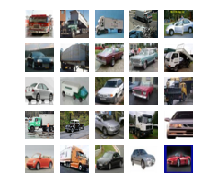

In [4]:
X = images_red.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
        

## Data normalization

Before running the SVM, it is always desirable to normalize our training data so each feature has zero sample mean and unit variance.

** Question 1 (1 point) **

Normalize your training and test data using the training **sample mean and std**.

In [5]:
# A function that normalizes data with pre-scecified mean and std. 
def normalize(X,mu=0,std=1,flag_train=True):
    if(flag_train):
        mu = np.mean(X,0)
        std = np.std(X,0)
    
    X -= mu
    X /= std
    
    return X,mu,std


img_norm, mu, std = normalize(images_red.astype(np.float64),mu=0,std=1,flag_train=True)

img_test_norm,_,_ = normalize(images_red_test.astype(np.float64),mu,std,flag_train=False)

## Training a Gaussian RBF SVC

** Question 2 (3 points) ** 

* Apply a 5-times cross validation to estimate the missclasification rate varying C from .01 to 100 (in log scale) with $\gamma$ equal to 1.
* Apply a 5-times cross validation to estimate the missclasification rate varying $\gamma$ from .01 to 10 (in log scale) and the best C obtained in the previous step
* Apply a 5-times cross validation to estimate the missclasification rate varying C and $\gamma$ around the best values obtained previously in steps 2x.

On the whole train data set:
* Train a single SVC with the best C and $\gamma$
* Evaluate the missclasification rate with the trained classifier
* **Check the number of suppor vectors**

On the test data set:
* Evaluate the missclasification rate with the trained classifier
* Try to plot to missclasified images and some correctly classified

Check [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to see how to use sklearn to easily obtain train/validation partitions for k-fold cross validation.

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#C from .0001 to 100(in log scale) with γ equal to 0.01
for exponent_C in range(-2,2):
    model_c = SVC(kernel='rbf', C=100 ** exponent_C, gamma=0.01)
    scores = cross_val_score(model_c, img_norm, labels_red, cv=5)
    print (scores)
    print("Gamma=0.01, C=%s, Error: %0.4f" % (100 ** exponent_C, 1-scores.mean()))

#γ from .000001 to .1 (in log scale) and the best C obtained in the previous step (100)
for gama in range(-3,1):
    model_g = SVC(kernel='rbf', C=100, gamma=100 ** gama)
    scores = cross_val_score(model_g, img_norm, labels_red, cv=5)
    print (scores)
    print("C=100, Gamma=%s, Error: %0.4f" % (100 ** gama, 1-scores.mean()))

[0.50255102 0.50127877 0.50127877 0.50127877 0.5025641 ]
Gamma=0.01, C=0.0001, Error: 0.4982
[0.50255102 0.50127877 0.50127877 0.50127877 0.5025641 ]
Gamma=0.01, C=0.01, Error: 0.4982
[0.50765306 0.50383632 0.50639386 0.50383632 0.5025641 ]
Gamma=0.01, C=1, Error: 0.4951
[0.5127551  0.50383632 0.50639386 0.50383632 0.5025641 ]
Gamma=0.01, C=100, Error: 0.4941
[0.70153061 0.70588235 0.71099744 0.69565217 0.68717949]
C=100, Gamma=1e-06, Error: 0.2998
[0.73469388 0.72122762 0.72378517 0.72890026 0.71282051]
C=100, Gamma=0.0001, Error: 0.2757
[0.5127551  0.50383632 0.50639386 0.50383632 0.5025641 ]
C=100, Gamma=0.01, Error: 0.4941
[0.50255102 0.50127877 0.50127877 0.50127877 0.5025641 ]
C=100, Gamma=1, Error: 0.4982


In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#C and γ around the best values obtained previously in steps 2x
model = SVC(kernel='rbf', C=100, gamma=0.0001)
scores = cross_val_score(model, img_norm, labels_red, cv=5)
print (scores)
print("Best: C=100, Gamma=0.0001, Error: %0.4f" % (1-scores.mean()))

#Evaluate the missclasification rate with the trained classifier
model.fit(img_norm, labels_red)
pred = model.predict(img_test_norm)
pred_train = model.predict(img_norm)
print("Test Score C=100 Gamma=0.0001 Error=%0.4f" %( 1 - accuracy_score(labels_red_test, pred)))
print("Train Score C=100 Gamma=0.0001 Error=%0.4f" %( 1 - accuracy_score(labels_red, pred_train)))
print("Number of support vectors: " , model.n_support_)

[0.73469388 0.72122762 0.72378517 0.72890026 0.71282051]
Best: C=100, Gamma=0.0001, Error: 0.2757
Test Score C=100 Gamma=0.0001 Error=0.3000
Train Score C=100 Gamma=0.0001 Error=0.0000
Number of support vectors:  [693 708]


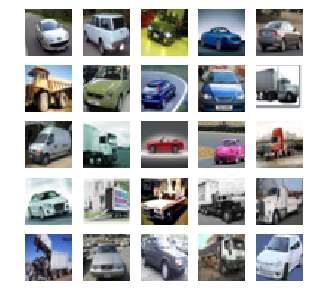

In [13]:
pred_correct = images_red_test[pred==labels_red_test]
X = pred_correct.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

fig, axes1 = plt.subplots(5,5,figsize=(5,5))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

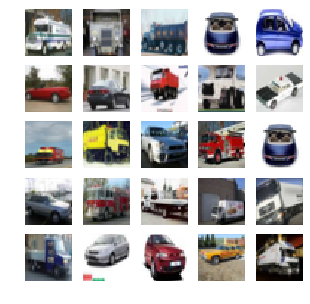

In [14]:
pred_incorrect = images_red_test[pred!=labels_red_test]
M = pred_incorrect.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

fig, axes1 = plt.subplots(5,5,figsize=(5,5))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(M)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(M[i:i+1][0])

## Training a Gaussian Polynomial SVC

** Question 3 (3 points) ** 

Set $\gamma=1$ in the polynomial kernel and then 
* Apply a 5-times cross validation to estimate the missclasification rate varying C from .01 to 100 (in log scale) with degree equal to 3.
* Apply a 5-times cross validation to estimate the missclasification rate varying degree from 1 (linear) to 5 and the best C obtained in the previous step.
* Apply a 5-times cross validation to estimate the missclasification rate using the best degree and varying C around the best value obtained previously in steps 2x.

On the whole train data set:
* Train a single SVC with the best C and degree

* Evaluate the missclasification rate with the trained classifier
* **Check the number of suppor vectors**

On the test data set:
* Evaluate the missclasification rate with the trained classifier
* Try to plot to missclasified images and some correctly classified

Check [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to see how to use sklearn to easily obtain train/validation partitions for k-fold cross validation.

In [22]:
#C from .0001 to 100 (in log scale) with γ equal to 0.0001
for exponent_C in range(-2,2):
    model_c = SVC(kernel='poly', C=100 ** exponent_C, gamma=0.0001)
    scores = cross_val_score(model_c, img_norm, labels_red, cv=5)
    print (scores)
    print("Gamma=0.0001, C=%s, Error: %0.4f" % (100 ** exponent_C, 1-scores.mean()))

#γ from .000001 to .1 (in log scale) and the best C obtained in the previous step (100)
for gama in range(-3,1):
    model_g = SVC(kernel='poly', C=100, gamma=100 ** gama)
    scores = cross_val_score(model_g, img_norm, labels_red, cv=5)
    print (scores)
    print("C=100, Gamma=%s, Error: %0.4f" % (100 ** gama, 1-scores.mean()))

[0.50255102 0.50127877 0.50127877 0.50127877 0.5025641 ]
Gamma=0.0001, C=0.0001, Error: 0.4982
[0.50255102 0.50127877 0.50127877 0.50127877 0.5025641 ]
Gamma=0.0001, C=0.01, Error: 0.4982
[0.55357143 0.58567775 0.56521739 0.56777494 0.55897436]
Gamma=0.0001, C=1, Error: 0.4338
[0.72704082 0.70588235 0.70588235 0.73401535 0.7025641 ]
Gamma=0.0001, C=100, Error: 0.2849
[0.50255102 0.50127877 0.50127877 0.50127877 0.5025641 ]
C=100, Gamma=1e-06, Error: 0.4982
[0.72704082 0.70588235 0.70588235 0.73401535 0.7025641 ]
C=100, Gamma=0.0001, Error: 0.2849
[0.74744898 0.67519182 0.69820972 0.73401535 0.66923077]
C=100, Gamma=0.01, Error: 0.2952
[0.74744898 0.67519182 0.69820972 0.73401535 0.66923077]
C=100, Gamma=1, Error: 0.2952


In [49]:
#C and γ around the best values obtained previously in steps 2x
model = SVC(kernel='poly', C=100, gamma=0.0001)
scores = cross_val_score(model, images_red, labels_red, cv=5)
print (scores)
print("Best: C=100, Gamma=0.0001, Error: %0.4f" % (1-scores.mean()))

#Evaluate the missclasification rate with the trained classifier
model.fit(img_norm, labels_red)
pred = model.predict(img_test_norm)
pred_train = model.predict(img_norm)
print("Test Score C=100 Gamma=0.0001 Error=%0.4f" %( 1 - accuracy_score(labels_red_test, pred)))
print("Train Score C=100 Gamma=0.0001 Error=%0.4f" %( 1 - accuracy_score(labels_red, pred_train)))
print("Number of support vectors: ", model.n_support_)

[0.7244898  0.7314578  0.71355499 0.74680307 0.69487179]
Best: C=100, Gamma=0.0001, Error: 0.2778
Test Score C=100 Gamma=0.0001 Error=0.2965
Train Score C=100 Gamma=0.0001 Error=0.0097
Number of support vectors:  [818 862]


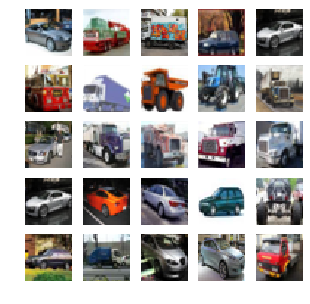

In [20]:
pred_correct = images_red_test[pred==labels_red_test]
X = pred_correct.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

fig, axes1 = plt.subplots(5,5,figsize=(5,5))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

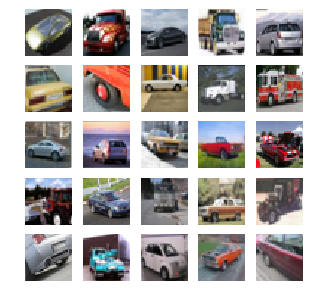

In [21]:
pred_incorrect = images_red_test[pred!=labels_red_test]
M = pred_incorrect.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

fig, axes1 = plt.subplots(5,5,figsize=(5,5))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(M)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(M[i:i+1][0])

## Doing some feature engineering

So far, you have essentially run your classifier without no feature engineering at all. While this may work, it is not a good idea in general.

** Question 4 (3 points) **

For each category, plot the mean of each features and try to understand if there are subsets of features (or new ones that could be created) where both categories can be separated away in a more effective way. If so, implement the SVC with the new set of features and evaluate the performance compared to the models you run before.

For instance, if we were comparing dogs & frogs, I would expect that the green levels in frog images would be higher than in dogs images.

**Note** There is no closed solution to this. I just want to make you think about your data ... 

Text(0.5,1,'Pixel Std in Train Set')

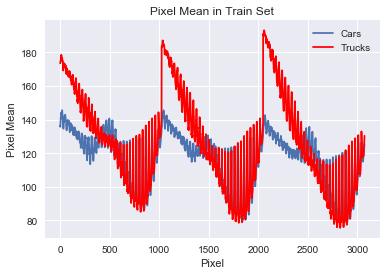

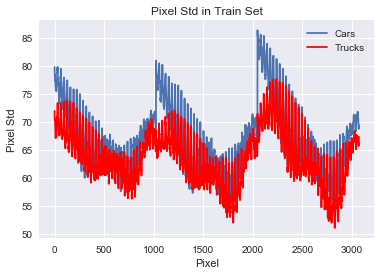

In [34]:
#The following code plots the pixel mean and std for images in each class

plt.plot(np.mean(images_red[labels_red==index_1,:],0),label='Cars')
plt.plot(np.mean(images_red[labels_red==index_2,:],0),'r',label='Trucks')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Pixel Mean')
plt.title('Pixel Mean in Train Set')

plt.figure()
plt.plot(np.std(images_red[labels_red==index_1,:],0),label='Cars')
plt.plot(np.std(images_red[labels_red==index_2,:],0),'r',label='Trucks')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Pixel Std')
plt.title('Pixel Std in Train Set')


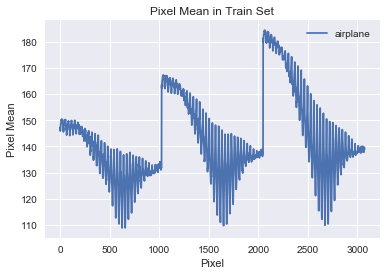

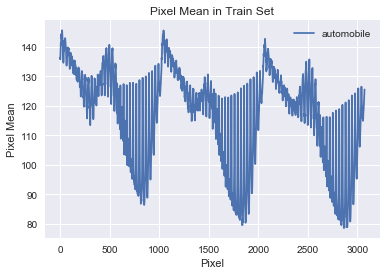

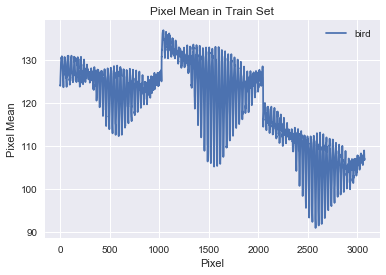

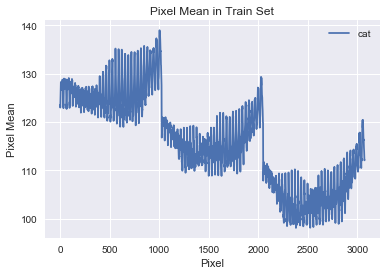

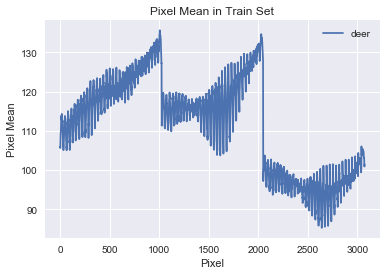

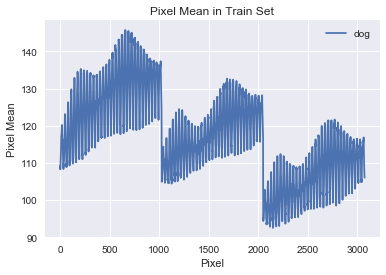

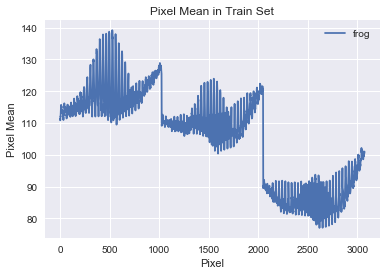

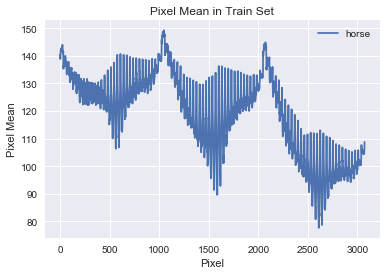

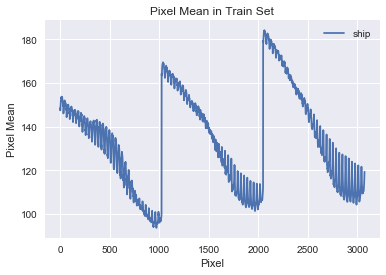

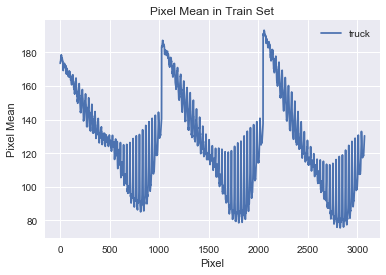

In [29]:
label_list=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for lab in range(0,10):
    plt.plot(np.mean(images[labels==lab,:],0), label=label_list[lab])
    plt.legend()
    plt.xlabel('Pixel')
    plt.ylabel('Pixel Mean')
    plt.title('Pixel Mean in Train Set')
    plt.show()

**Pixels with biggest mean differences will help to differanciate them**

In [65]:
print ("Gaussian RBF SVC")
dif_list=np.absolute(np.subtract(np.mean(images_red[labels_red==index_2,:],0), np.std(images_red[labels_red==index_2,:],0)))
model = SVC(kernel='rbf', C=100, gamma=0.0001)
better_list_rbf=[]

for index in range(100,1001,100):
    high_dif_indexes=dif_list.argsort()[index:][::-1]
    model.fit(img_norm[:,high_dif_indexes], labels_red)
    pred = model.predict(img_test_norm[:,high_dif_indexes])
    print("Test Score: Greatest %s index C=100 Gamma=0.0001 Error=%0.4f" %(index , 1 - accuracy_score(labels_red_test, pred)))
    if (1 - accuracy_score(labels_red_test, pred) < 0.3000): 
        better_list_rbf.append(index)
print("number of indexes with better result than the first approach: ")
print(better_list_rbf)

Gaussian RBF SVC
Test Score: Greatest 100 index C=100 Gamma=0.0001 Error=0.3010
Test Score: Greatest 200 index C=100 Gamma=0.0001 Error=0.3055
Test Score: Greatest 300 index C=100 Gamma=0.0001 Error=0.3085
Test Score: Greatest 400 index C=100 Gamma=0.0001 Error=0.3050
Test Score: Greatest 500 index C=100 Gamma=0.0001 Error=0.3125
Test Score: Greatest 600 index C=100 Gamma=0.0001 Error=0.3060
Test Score: Greatest 700 index C=100 Gamma=0.0001 Error=0.3090
Test Score: Greatest 800 index C=100 Gamma=0.0001 Error=0.3095
Test Score: Greatest 900 index C=100 Gamma=0.0001 Error=0.3090
Test Score: Greatest 1000 index C=100 Gamma=0.0001 Error=0.3095
number of indexes with better result than the first approach: 
[]


**I tried to reduce dimension by using the mean differences with Gaussian RBF SVC. I used a loop to obtain test error score for 100...1000 biggest mean difference pixels. There were no important difference between using 100 variables and using all (errors are 0.3010 and 0.3 respectively). So, it would be a good idea to reduce the dimension if its your need in this case.**

In [62]:
print ("Gaussian Polynomial SVC")
model = SVC(kernel='poly', C=100, gamma=0.0001)
better_list_poly=[]

for index in range(100,1001,100):
    high_dif_indexes=dif_list.argsort()[index:][::-1]
    model.fit(img_norm[:,high_dif_indexes], labels_red)
    pred = model.predict(img_test_norm[:,high_dif_indexes])
    print("Test Score: Greatest %s index C=100 Gamma=0.0001 Error=%0.4f" %(index , 1 - accuracy_score(labels_red_test, pred)))
    if (1 - accuracy_score(labels_red_test, pred) < 0.2965): 
        better_list_poly.append(index)
print("number of indexes with better result than the first approach: ")
print(better_list_poly)

Gaussian Polynomial SVC
Test Score: Greatest 100 index C=100 Gamma=0.0001 Error=0.2945
Test Score: Greatest 200 index C=100 Gamma=0.0001 Error=0.2940
Test Score: Greatest 300 index C=100 Gamma=0.0001 Error=0.2945
Test Score: Greatest 400 index C=100 Gamma=0.0001 Error=0.2925
Test Score: Greatest 500 index C=100 Gamma=0.0001 Error=0.2955
Test Score: Greatest 600 index C=100 Gamma=0.0001 Error=0.3005
Test Score: Greatest 700 index C=100 Gamma=0.0001 Error=0.3035
Test Score: Greatest 800 index C=100 Gamma=0.0001 Error=0.3150
Test Score: Greatest 900 index C=100 Gamma=0.0001 Error=0.3120
Test Score: Greatest 1000 index C=100 Gamma=0.0001 Error=0.3170
number of indexes with better result than the first approach: 
[100, 200, 300, 400, 500]


**I tried to reduce the dimension by using the mean differences with Gaussian Polynomial SVC. I used a loop to obtain test error score for 100...1000 biggest mean difference pixels. It gave even better test error scores using 100, 200, 300, 400, 500 variables than using all. So, it is a good idea to reduce the dimension both to get better accuracy and less complexity.**